In [1]:
# %pip install -Uq diffusers ftfy accelerate

In [2]:
# Installing transformers from source for now since we need the latest version for Depth2Img
# %pip install -Uq git+https://github.com/huggingface/transformers 

In [3]:
# install pytorch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1

import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(torch.cuda.is_available())

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline
)       



# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

True


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.3.0+cu121 with CUDA 1201 (you have 2.4.1+cu121)
    Python  3.10.11 (you have 3.10.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "f:\python3.10\lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
  File "f:\python3.10\lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'
f:\python3.10\lib\site-packages\xformers\ops\swiglu_op.py:107: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fw

In [4]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [5]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

f:\python3.10\lib\site-packages\transformers\models\clip\modeling_clip.py:540: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

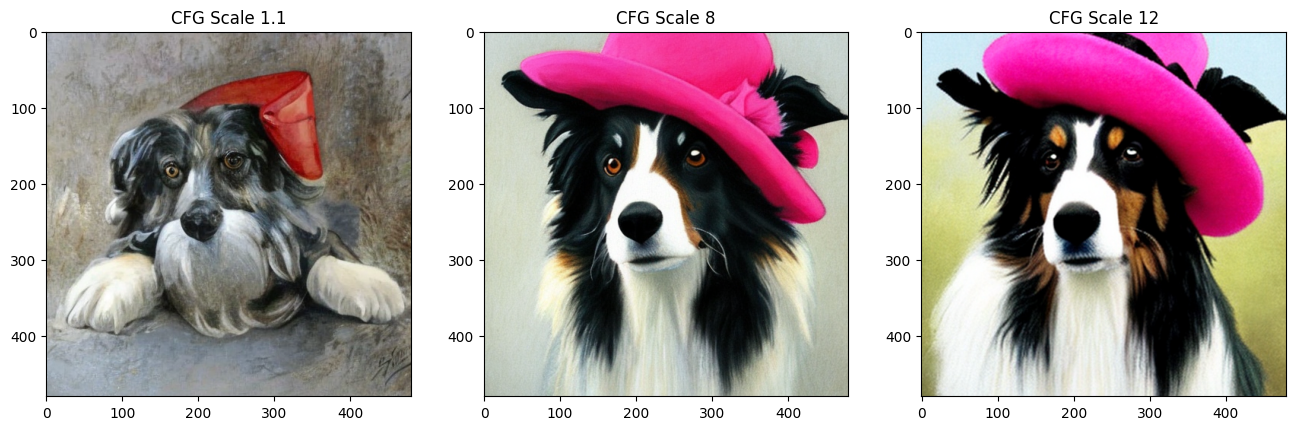

In [ ]:
#@markdown comparing guidance scales:
cfg_scales = [1.1, 8, 12] #@param
prompt = "A collie with a pink hat" #@param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

In [ ]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


# VAE 
The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this 'latent' representation back into something close to the original input. When generating images with Stable Diffusion, we first generate the latents by applying the diffusion process in the 'latent space' of the VAE, and then decode them at the end to view the resulting image.

Here is some code that takes an input image, encodes it to a latent representation and then decodes it again using the VAE:

In [ ]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


As you can see, the 512x512 image is compressed to a 64x64 latent representation (with four channels). This 8x reduction in each spatial dimension is the reason the specified width and height need to be multiples of 8.

Working with these information-rich 4x64x64 latents is more efficient than working with massive 512px images, allowing for faster diffusion models that take less resources to train and use. The VAE decoding process is not perfect, but it is good enough that the small quality tradeoff is generally worth it.

NB: The code example above includes the scaling factor of 0.18215 required to match the processing used during SD's training.

In [ ]:
# The Tokenizer and Text Encoder


In [ ]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [ ]:
# Get the final text embeddings using the pipeline's encode_prompt function
# text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, False, '')
# text_embeddings.shape

TypeError: expected Tensor as element 0 in argument 0, but got NoneType

# The UNet
The UNet takes a noisy input and predicts the noise, just like the UNets we've seen in previous units. Unlike those previous examples, the input is not an image but is instead a latent representation of an image. And in addition to the timestep conditioning, this UNet also takes in the text embeddings of the prompt as an additional input. Here it is making predictions on some dummy data:

In [ ]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


# The Scheduler

C:\Users\chcbb\AppData\Local\Temp\ipykernel_15640\3105225182.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.title('Noise schedule');plt.legend();


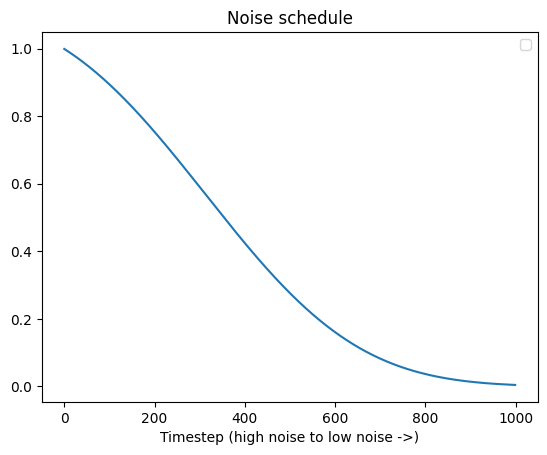

In [ ]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

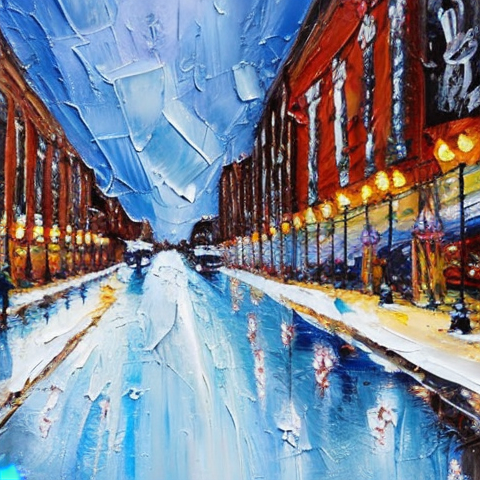

In [ ]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]
     

# A DIY Sampling Loop

f:\python3.10\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:589: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


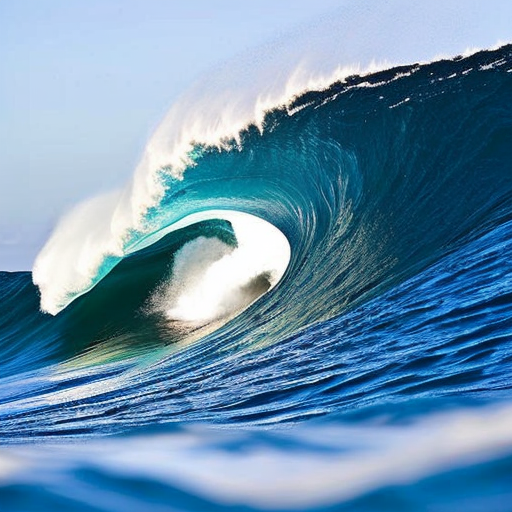

In [ ]:
guidance_scale = 8 #@param
num_inference_steps = 30 #@param
prompt = "Beautiful picture of a wave breaking" #@param
negative_prompt = "zoomed in, blurry, oversaturated, warped" #@param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # Expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]